In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")
# sys.path.append(r"/users/mjk557/scratch/scripts/sdtools/hermes3")

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.casedeck import *

%load_ext autoreload
%autoreload 2

/ssd_scratch/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
db = CaseDB(
    case_dir = r"/ssd_scratch/cases",
    grid_dir = r"/ssd_scratch/cases"
    )

cases = {}
cases["base"] = Load.case_1D(db.casepaths["t1cc-nochanges"])
# cases["slope"] = Load.case_1D(db.casepaths["t1c-ar_ne_n_c_shorttest"])
# cases["midpoint"] = Load.case_1D(db.casepaths["t1cb-midpoint_average"])

In [3]:
fit_ne = {'coeffs': np.array([-8.21475117e+01,  1.28929853e+01, -4.74266288e+01,  7.45222323e+01,
       -5.75710721e+01,  2.57375965e+01, -7.12758563e+00,  1.24287546e+00,
       -1.32943407e-01,  7.97368445e-03, -2.05487897e-04]), 'limit_values': (6.353041126728376e-36, 1.1789462767573414e-32), 'fit_limits': (2, 1000)}


def get_Lz_rate(Te, coeffs, limit_values, fit_limits):
            
    logT = np.log(Te)
    log_out = 0

    if Te >= fit_limits[0] and Te <= fit_limits[1]:
        log_out = log_out          \
        +(coeffs[0]) * pow(logT, 0) \
        +(coeffs[1]) * pow(logT, 1) \
        +(coeffs[2]) * pow(logT, 2) \
        +(coeffs[3]) * pow(logT, 3) \
        +(coeffs[4]) * pow(logT, 4) \
        +(coeffs[5]) * pow(logT, 5) \
        +(coeffs[6]) * pow(logT, 6) \
        +(coeffs[7]) * pow(logT, 7) \
        +(coeffs[8]) * pow(logT, 8) \
        +(coeffs[9]) * pow(logT, 9) \
        +(coeffs[10]) * pow(logT, 10) 
        return np.exp(log_out)

    elif Te < fit_limits[0]:
        return limit_values[0]

    else:
        return limit_values[1]


    

# Case comparison

Error for base: -0.0009372780784602359


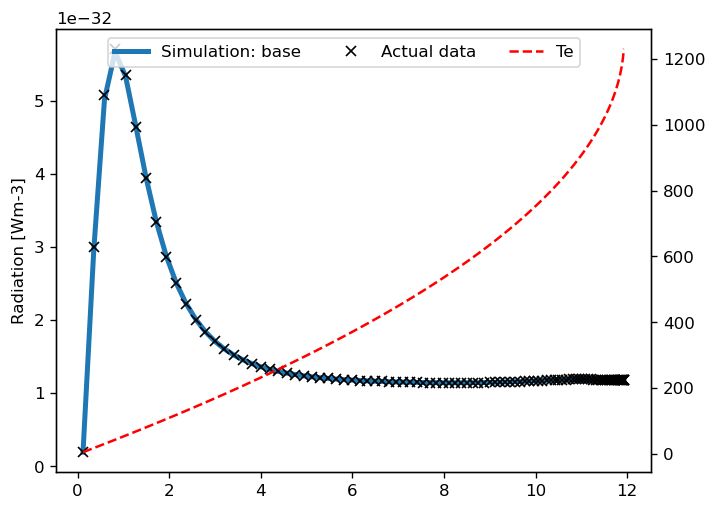

In [4]:



fig, ax = plt.subplots(dpi = 120)


for name in cases:
    ds = cases[name].ds.isel(t=-1, pos = slice(2,-2))
    m = ds.metadata
    Te = ds["Te"].values
    Ne = ds["Ne"].values
    pos = ds["pos"].values

    R = ds[f"Rne"] 
    Lz = R / (ds["Ne"] * ds["Ne"] * 0.002)
    Lz_full = [get_Lz_rate(x, fit_ne["coeffs"], fit_ne["limit_values"], fit_ne["fit_limits"]) for x in Te]
    
    ax.plot(pos, Lz, label = f"Simulation: {name}", marker = "o", ms = 0, lw = 3)
    
    error = (np.sum(Lz) - np.sum(Lz_full)) / np.sum(Lz_full)
    
    print(f"Error for {name}: {error}")

# ax.plot(pos, R_intended, label = "intended", color = "teal", marker = "o", ms = 6, lw = 0)
# ax.plot(pos, R, label = "Model", color = "darkorange", marker = "o", ms = 3)

ax.plot(pos[::1], Lz_full[::1], label = "Actual data", color = "black", marker = "x", ms = 6, lw = 0)
# ax.plot(pos, Lz_test, label = "test", color = "deeppink", marker = "o", ms = 6, lw = 0)
# ax.set_yscale("log")
ax.set_ylabel("Radiation [Wm-3]")

ax2 = ax.twinx()
ax2.plot(pos, Te, label = "Te", c = "r", ls = "--")
# styles = plt.style.available
fig.legend(ncols = 4, bbox_to_anchor=(0.5,0.8), loc = "lower center")

# with plt.style.context('stylename'):
#     make_a_plot()

In [11]:
df = pd.DataFrame()
df["model"] = Lz
df["data"] = Lz_full

df["error"] = (df["model"] - df["data"]) / df["data"]

df

,model,data,error
0,4.229527e-33,1.942351e-33,1.177530e+00
1,2.966522e-32,3.004260e-32,-1.256139e-02
2,5.019043e-32,5.083476e-32,-1.267500e-02
3,5.667455e-32,5.708611e-32,-7.209487e-03
4,5.335676e-32,5.349154e-32,-2.519674e-03
...,...,...,...
95,1.178946e-32,1.178946e-32,-5.988034e-09
96,1.178946e-32,1.178946e-32,-6.111944e-09
97,1.178946e-32,1.178946e-32,-1.860877e-08
98,1.178946e-32,1.178946e-32,-2.758627e-07


In [9]:
Lz.values - Lz_full.values

AttributeError: 'list' object has no attribute 'values'

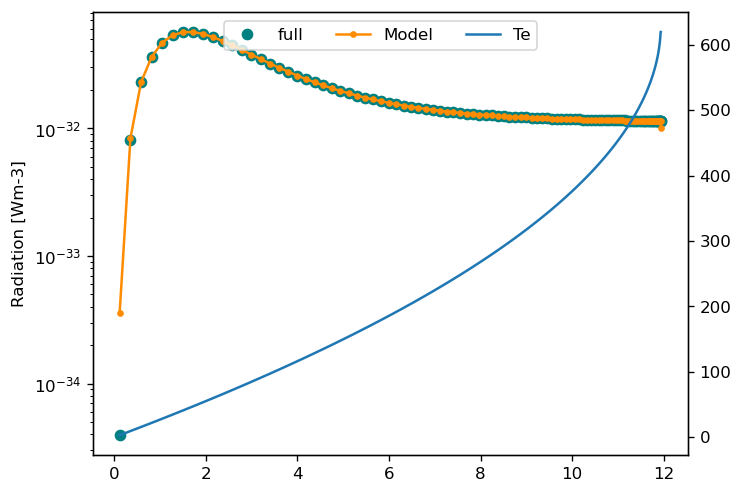

In [6]:
ds = case.ds.isel(t=-1, pos = slice(2,-2))
m = ds.metadata
Te = ds["Te"].values
Ne = ds["Ne"].values
pos = ds["pos"].values


fig, ax = plt.subplots(dpi = 120)


Lz_full = [get_Lz_rate(x, fit_ne["coeffs"], fit_ne["limit_values"], fit_ne["fit_limits"]) for x in Te]
# Lz_intended = [RyokoNeon(x) for x in Te]
# Lz_intended = [funtest(x) for x in Te]
Lz_test = [funtest2(x, coeffs) for x in Te]
# R_intended = Lz_intended * Ne * Ne * 0.002


R = ds[f"Rne"] 
Lz = R / (ds["Ne"] * ds["Ne"] * 0.002)

# ax.plot(pos, R_intended, label = "intended", color = "teal", marker = "o", ms = 6, lw = 0)
# ax.plot(pos, R, label = "Model", color = "darkorange", marker = "o", ms = 3)

ax.plot(pos, Lz_full, label = "full", color = "teal", marker = "o", ms = 6, lw = 0)
# ax.plot(pos, Lz_test, label = "test", color = "deeppink", marker = "o", ms = 6, lw = 0)
ax.plot(pos, Lz, label = "Model", color = "darkorange", marker = "o", ms = 3)


ax.set_yscale("log")
ax.set_ylabel("Radiation [Wm-3]")

ax2 = ax.twinx()
ax2.plot(pos, Te, label = "Te")
# styles = plt.style.available
fig.legend(ncols = 4, bbox_to_anchor=(0.5,0.8), loc = "lower center")

# with plt.style.context('stylename'):
#     make_a_plot()

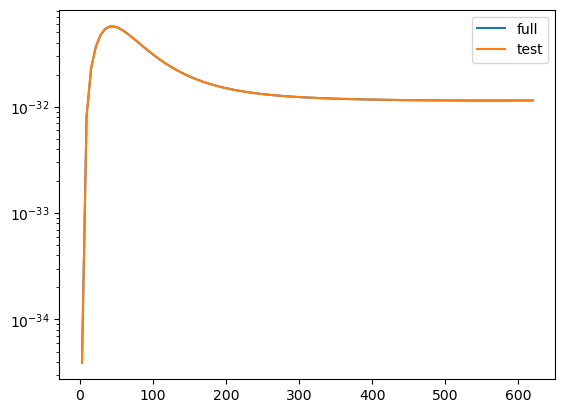

In [9]:
    
def funtest2(Te, coeffs):
    logT = np.log(Te)
    log_out = 0
    log_out = log_out          \
    +(coeffs[0]) * pow(logT, 0) \
    +(coeffs[1]) * pow(logT, 1) \
    +(coeffs[2]) * pow(logT, 2) \
    +(coeffs[3]) * pow(logT, 3) \
    +(coeffs[4]) * pow(logT, 4) \
    +(coeffs[5]) * pow(logT, 5) \
    +(coeffs[6]) * pow(logT, 6) \
    +(coeffs[7]) * pow(logT, 7) \
    +(coeffs[8]) * pow(logT, 8) \
    +(coeffs[9]) * pow(logT, 9) \
    +(coeffs[10]) * pow(logT, 10) 
    
    return np.exp(log_out)

def get_Lz_rate(Te, coeffs, limit_values, fit_limits):
            
    logT = np.log(Te)
    log_out = 0

    if Te >= fit_limits[0] and Te <= fit_limits[1]:
        log_out = log_out          \
        +(coeffs[0]) * pow(logT, 0) \
        +(coeffs[1]) * pow(logT, 1) \
        +(coeffs[2]) * pow(logT, 2) \
        +(coeffs[3]) * pow(logT, 3) \
        +(coeffs[4]) * pow(logT, 4) \
        +(coeffs[5]) * pow(logT, 5) \
        +(coeffs[6]) * pow(logT, 6) \
        +(coeffs[7]) * pow(logT, 7) \
        +(coeffs[8]) * pow(logT, 8) \
        +(coeffs[9]) * pow(logT, 9) \
        +(coeffs[10]) * pow(logT, 10) 
        return np.exp(log_out)

    elif Te < fit_limits[0]:
        return limit_values[0]

    else:
        return limit_values[1]

Te_array = np.linspace(0, 1500, 100)

coeffs = np.array([-8.21475117e+01,  1.28929853e+01, -4.74266288e+01,  7.45222323e+01,
       -5.75710721e+01,  2.57375965e+01, -7.12758563e+00,  1.24287546e+00,
       -1.32943407e-01,  7.97368445e-03, -2.05487897e-04])

Lz_full = [get_Lz_rate(x, coeffs, fit_ne["limit_values"], fit_ne["fit_limits"]) for x in Te]
Lz_test = [funtest2(x, coeffs) for x in Te]

# Lz_test = Te_array**2 + Te_array

fig, ax = plt.subplots()
ax.plot(Te, Lz_full, label = "full")
ax.plot(Te, Lz_test, label = "test")
ax.legend()
ax.set_yscale("log")

In [ ]:

def RyokoArgon(T):
    answer = 0
    if T >= 1.5 and T<= 100:
        answer = -4.9692e-48*T**10 + 2.8025e-45*T**9 -6.7148e-43*T**8 + 8.8636e-41*T**7 -6.9642e-39*T**6 +3.2559e-37*T**5 -8.3410e-36*T**4 +8.6011e-35*T**3 +1.9958e-34*T**2 + 4.9864e-34*T -9.9412e-34
    elif T >= 1.0 and T< 1.5:
        answer = 2.5E-35/(1.5-1.0)*(T-1.0)
    else:
        answer = 0
    return answer

def RyokoNeon(T):    
    answer = 0
    if T >= 3 and T<= 100:
        answer = -2.0385E-40*T**5 + 5.4824E-38*T**4 -5.1190E-36*T**3 + 1.7347E-34*T**2 -3.4151E-34*T -3.2798E-34
    elif T >=2 and T < 3:
        answer = (8.0-1.0)*1.0E-35/(3.0-2.0)*(T-2.0)+1.0E-35
    elif T >=1 and T < 2:
        answer = 1.0E-35/(2.0-1.0)*(T-1.0)
    else:
        answer = 0
    return answer


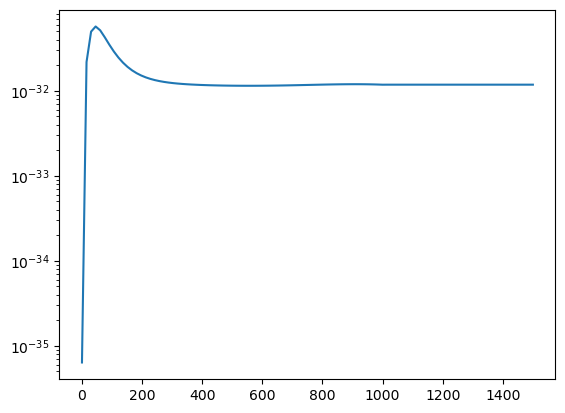

In [ ]:
Te_array = np.linspace(0, 1500, 100)

coefftest = np.array([-8.21475117e+01,  1.28929853e+01, -4.74266288e+01,  7.45222323e+01,
       -5.75710721e+01,  2.57375965e+01, -7.12758563e+00,  1.24287546e+00,
       -1.32943407e-01,  7.97368445e-03, -2.05487897e-04])

Lz_test = [get_Lz_rate(x, coefftest, fit_ne["limit_values"], fit_ne["fit_limits"]) for x in Te_array]

# Lz_test = Te_array**2 + Te_array

fig, ax = plt.subplots()
ax.plot(Te_array, Lz_test)
ax.set_yscale("log")

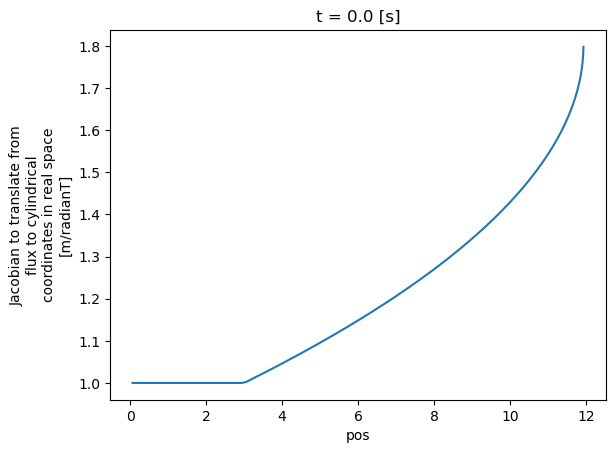

In [8]:
ds["J"].plot()

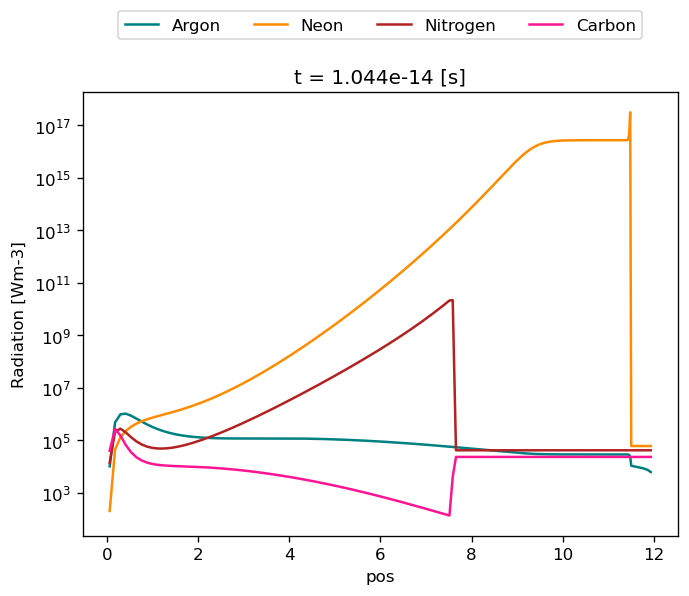

In [14]:
ds = case.ds.isel(t=-1, pos = slice(2,-2))

fig, ax = plt.subplots(dpi = 120)

colors = ["teal", "darkorange", "firebrick", "deeppink"]

species_names = dict(
    ar = "Argon", 
    ne = "Neon", 
    n = "Nitrogen", 
    c = "Carbon"
    )

for i, species in enumerate(species_names):
    
    ds[f"R{species}"].plot(ax = ax, label = species_names[species], color = colors[i])
    # intended = [fitfuncs[species](x) for x in ds["Te"].values] * ds["Ne"] * (ds["Ne"] * 0.002)
    # ax.scatter(ds["pos"][::4], intended[::4], color = colors[i], s=8, marker = "v")
    
    # print(f"************")
    # print(species)
    # print(f"Error: {(intended.sum() - ds[f'R{species}'].sum()) / intended.sum()}")
    

ax.set_yscale("log")
ax.set_ylabel("Radiation [Wm-3]")

ax.legend(ncols = 4, bbox_to_anchor=(0.5,1.1), loc = "lower center")
# styles = plt.style.available


# with plt.style.context('stylename'):
#     make_a_plot()

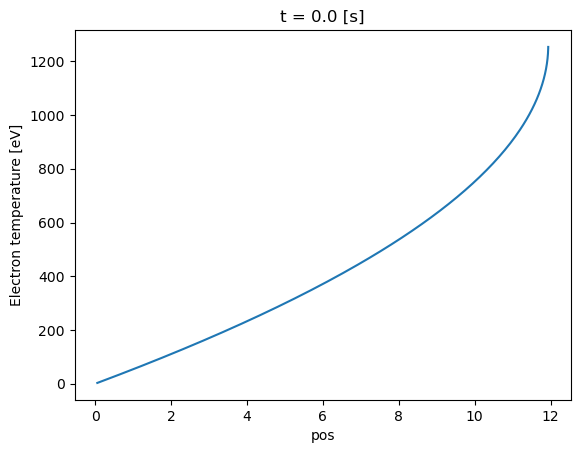

In [9]:
ds = case.ds.isel(t=0, pos = slice(2,-2))
m = ds.metadata
(ds["Te"]).plot()

In [ ]:
def get_Lz_rate(Te, coeffs, limit_values, fit_limits):
            
    # Replicate any rounding error in Hermes-3
    rounding = 10
    def scientific_round(x):
        return float(np.format_float_scientific(x, precision = rounding))
    
    logT = np.log(Te)
    log_out = 0

    if Te >= fit_limits[0] and Te <= fit_limits[1]:
        log_out = log_out          \
        +np.round(scientific_round(coeffs[0]), rounding) * pow(logT, 0) \
        +np.round(scientific_round(coeffs[1]), rounding) * pow(logT, 1) \
        +np.round(scientific_round(coeffs[2]), rounding) * pow(logT, 2) \
        +np.round(scientific_round(coeffs[3]), rounding) * pow(logT, 3) \
        +np.round(scientific_round(coeffs[4]), rounding) * pow(logT, 4) \
        +np.round(scientific_round(coeffs[5]), rounding) * pow(logT, 5) \
        +np.round(scientific_round(coeffs[6]), rounding) * pow(logT, 6) \
        +np.round(scientific_round(coeffs[7]), rounding) * pow(logT, 7) \
        +np.round(scientific_round(coeffs[8]), rounding) * pow(logT, 8) \
        +np.round(scientific_round(coeffs[9]), rounding) * pow(logT, 9) \
        +np.round(scientific_round(coeffs[10]),rounding) * pow(logT, 10) 
        return np.exp(log_out)

    elif Te < fit_limits[0]:
        return limit_values[0]

    else:
        return limit_values[1]